この章では、text to imageではなく、image to text、つまりテキストから画像を生成する流れを実装していきます。</br>

In [13]:

import math
# テンソルを見やすく表示する関数（スキップしても構いません）
import torch
import torch.nn as nn

def print_formatted_tensor(*args, width=6, decimals=2):
    """
    
    A function that neatly formats and displays a PyTorch Tensor, and also prints its size.

    Example usage:
        print_formatted_tensor("名前", tensor)
        print_formatted_tensor(tensor)

    Args:
        *args: If given 1 argument, it is treated as a tensor.
               If given 2 arguments, the first is treated as the name, the second as the tensor.
        width (int): Display width for each number (default: 6)
        decimals (int): Number of decimal places to show (default: 2)
    """
    

    # 引数からテンソルと名前を決定する
    if not args:
        raise ValueError("At least one argument is required.")
    if isinstance(args[0], str):
        if len(args) < 2:
            raise ValueError("Tensor is not specified.")
        name, tensor = args[0], args[1]
    else:
        name, tensor = None, args[0]

    # Tensorをリストに変換する
    tensor_list = tensor.detach().cpu().tolist()

    def format_list(lst, indent):
        """再帰的に入れ子になったリストを整形して文字列を返す"""
        # 内容がリストの場合は再度返す
        if isinstance(lst, list) and lst and isinstance(lst[0], list):
            inner = ",\n".join(" " * indent + format_list(sub, indent + 2) for sub in lst)
            return "[\n" + inner + "\n" + " " * (indent - 2) + "]"
        # 数字リストの場合
        return "[" + ", ".join(f"{v:{width}.{decimals}f}" for v in lst) + "]"

    # フォーマット済み文字列（最外枠の角括弧は削除されます）
    formatted = format_list(tensor_list, indent=9)
    inner_formatted = formatted[1:-1].strip()

    # 結果出力
    if name:
        print(name)
    print(f"Tensor Size: {list(tensor.size())}")
    print("tensor([")
    print(" " * 9 + inner_formatted)
    print(" " * 7 + "])")



torch.manual_seed(1337)

# Chapter 1 データセットの確認
まずはデータセットをチラ見するところからです。 

In [14]:
import json

with open('../../files/caption_datasets/dataset_flickr8k.json', 'r') as fb:
    data = json.load(fb)

今回利用するデータセットはflickr-8kと言われるキャプション付きのデータセットです。8000枚ものデータに対して手入力でキャプションをつけてくれています。感謝しながら行きましょう。

In [18]:
data

{'images': [{'sentids': [0, 1, 2, 3, 4],
   'imgid': 0,
   'sentences': [{'tokens': ['a',
      'black',
      'dog',
      'is',
      'running',
      'after',
      'a',
      'white',
      'dog',
      'in',
      'the',
      'snow'],
     'raw': 'A black dog is running after a white dog in the snow .',
     'imgid': 0,
     'sentid': 0},
    {'tokens': ['black', 'dog', 'chasing', 'brown', 'dog', 'through', 'snow'],
     'raw': 'Black dog chasing brown dog through snow',
     'imgid': 0,
     'sentid': 1},
    {'tokens': ['two',
      'dogs',
      'chase',
      'each',
      'other',
      'across',
      'the',
      'snowy',
      'ground'],
     'raw': 'Two dogs chase each other across the snowy ground .',
     'imgid': 0,
     'sentid': 2},
    {'tokens': ['two', 'dogs', 'play', 'together', 'in', 'the', 'snow'],
     'raw': 'Two dogs play together in the snow .',
     'imgid': 0,
     'sentid': 3},
    {'tokens': ['two',
      'dogs',
      'running',
      'through',
     

In [22]:
from collections import Counter
from pathlib import Path

# ノートブック/スクリプトのどちらでも現在位置を解決
try:
    HERE = Path(__file__).parent
except NameError:
    HERE = Path.cwd()

# 画像ディレクトリを相対パスで指定（notebooks/answer/ から ../../archive/Images/）
IMAGES_DIR = (HERE / "../../archive/Images").resolve()
if not IMAGES_DIR.exists():
    raise FileNotFoundError(f"Images dir not found: {IMAGES_DIR}")

train_image_paths = []
train_image_captions = []
test_image_paths = []
test_image_captions = []
word_freq = Counter()

max_len = 50

for img in data["images"]:
    captions = []
    for c in img["sentences"]:
        tokens = c["tokens"]
        word_freq.update(tokens)                 # A
        if len(tokens) <= max_len:
            captions.append(tokens)              # B

    if not captions:
        continue

    path = str(IMAGES_DIR / img["filename"])     # ← ローカル相対パスに変更

    # Flickr8k の split は train/val/test を想定。restval も一応対応
    if img["split"] in {"train", "val", "restval"}:   # C
        train_image_paths.append(path)
        train_image_captions.append(captions)
    elif img["split"] in {"test"}:                     # D
        test_image_paths.append(path)
        test_image_captions.append(captions)


データセットのプロフィールを見てみましょう。

In [24]:
assert len(train_image_paths)==len(train_image_captions)
assert len(test_image_paths)==len(test_image_captions)
print(f"there are {len(train_image_paths)} training images")
print(f"there are {len(test_image_paths)} test images")


there are 7000 training images
there are 1000 test images


画像とキャプションの組を見てみましょう。

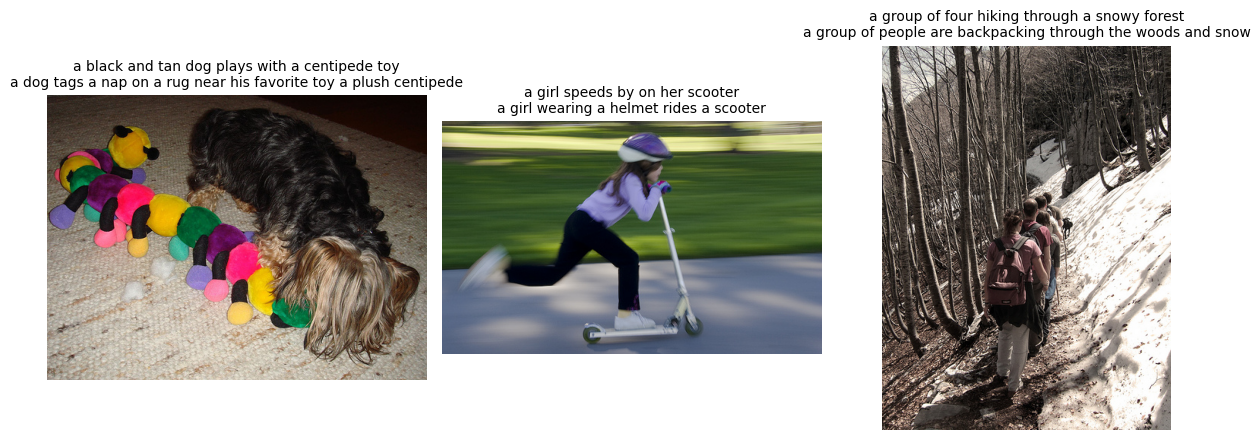

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# 画像とキャプションの組を可視化する関数
# このコードは理解不要です。

def show_image_caption_pairs(split: str = "train", num_samples: int = 4, captions_per_image: int = 1, seed: int | None = 1337):
    """
    指定した split (train/test) から、画像とキャプションの組をランダムに num_samples 個表示します。

    Args:
        split (str): "train" または "test"
        num_samples (int): 表示する画像枚数
        captions_per_image (int): 各画像につき表示するキャプション数（上限）
        seed (int|None): ランダムシード
    """
    if seed is not None:
        random.seed(seed)

    if split not in {"train", "test"}:
        raise ValueError("split は 'train' か 'test' を指定してください。")

    # 必要変数の存在チェック
    required_vars = [
        'train_image_paths', 'train_image_captions',
        'test_image_paths', 'test_image_captions'
    ]
    for var_name in required_vars:
        if var_name not in globals():
            raise RuntimeError(f"変数 {var_name} が見つかりません。前のセルを実行してください。")

    if split == "train":
        paths = train_image_paths
        caps = train_image_captions
    else:
        paths = test_image_paths
        caps = test_image_captions

    if len(paths) == 0:
        raise RuntimeError(f"{split} の画像パスが空です。前処理セルを確認してください。")

    # サンプル選択
    indices = random.sample(range(len(paths)), k=min(num_samples, len(paths)))

    cols = min(4, num_samples)
    rows = (num_samples + cols - 1) // cols

    plt.figure(figsize=(4 * cols, 4.5 * rows))

    for i, idx in enumerate(indices, start=1):
        img_path = paths[idx]
        captions_token_lists = caps[idx]  # list[list[str]]

        try:
            # 画像の読み込み（ノートブックからの相対パスを解決）
            # 既に paths は '../../archive/Images/filename.jpg' 形式なので、そのまま開けるはず
            with Image.open(img_path) as im:
                image = im.convert("RGB")
        except FileNotFoundError:
            # 万が一相対パスがずれていた場合のフォールバック
            alt_path = os.path.join("../../archive/Images", os.path.basename(img_path))
            with Image.open(alt_path) as im:
                image = im.convert("RGB")

        # キャプション整形
        shown_caps = []
        for tokens in captions_token_lists[:captions_per_image]:
            if isinstance(tokens, list):
                shown_caps.append(" ".join(tokens))
            else:
                shown_caps.append(str(tokens))

        title = "\n".join(shown_caps)

        ax = plt.subplot(rows, cols, i)
        ax.imshow(image)
        ax.set_title(title, fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# 例: 学習データから 6 枚表示
show_image_caption_pairs(split="train", num_samples=3, captions_per_image=2)


データセットを見てみると、２文構成になっていることが読み取れると思います。</br>
２文でその状況を端的に表すことが記述されていますね。

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt


def show_image_by_index(split: str = "test", idx: int = 0, show_all_captions: bool = True):
    """
    指定した split の idx 番目の画像を表示し、対応するキャプションを併記します。
    `test_image_captions[idx]` に対応する画像が表示されます。
    """
    if split not in {"train", "test"}:
        raise ValueError("split は 'train' または 'test' を指定してください。")

    if split == "train":
        paths = train_image_paths
        caps = train_image_captions
    else:
        paths = test_image_paths
        caps = test_image_captions

    if not (0 <= idx < len(paths)):
        raise IndexError(f"idx は 0 以上 {len(paths)-1} 以下で指定してください。与えられた idx={idx}")

    img_path = paths[idx]

    try:
        with Image.open(img_path) as im:
            image = im.convert("RGB")
    except FileNotFoundError:
        alt_path = os.path.join("../../archive/Images", os.path.basename(img_path))
        with Image.open(alt_path) as im:
            image = im.convert("RGB")

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')

    # タイトルにキャプション（複数ある場合は改行して表示）
    captions_token_lists = caps[idx]
    if show_all_captions:
        texts = [" ".join(tokens) if isinstance(tokens, list) else str(tokens) for tokens in captions_token_lists]
    else:
        tokens = captions_token_lists[0]
        texts = [" ".join(tokens) if isinstance(tokens, list) else str(tokens)]

    plt.title("\n".join(texts), fontsize=10)
    plt.show()

# 例: 質問の `test_image_captions[0][0]` に対応する画像を表示
# show_image_by_index(split="test", idx=0, show_all_captions=True)


In [ ]:
# 学習データからランダムに画像とキャプションを可視化（グリッド表示）
show_image_caption_pairs(split="train", num_samples=6, captions_per_image=2, seed=1337)


In [ ]:
# `test_image_captions[0][0]` に対応する画像を単体表示
show_image_by_index(split="test", idx=0, show_all_captions=True)


# Chapter 2: トークンの作成

それではまずはテキストを数字に変換する辞書を作っていきます。</br>
今までもやっていたテキストの置き換えです。</br>
すべての単語に番号を振るロジックを立てます

In [30]:
min_word_freq=0
words = [w for w in word_freq.keys() if word_freq[w]>min_word_freq]
word2idx = {k:v + 4 for v,k in enumerate(words)}

In [31]:
word2idx 

{'a': 4,
 'black': 5,
 'dog': 6,
 'is': 7,
 'running': 8,
 'after': 9,
 'white': 10,
 'in': 11,
 'the': 12,
 'snow': 13,
 'chasing': 14,
 'brown': 15,
 'through': 16,
 'two': 17,
 'dogs': 18,
 'chase': 19,
 'each': 20,
 'other': 21,
 'across': 22,
 'snowy': 23,
 'ground': 24,
 'play': 25,
 'together': 26,
 'low': 27,
 'lying': 28,
 'body': 29,
 'of': 30,
 'water': 31,
 'little': 32,
 'baby': 33,
 'plays': 34,
 'croquet': 35,
 'girl': 36,
 'next': 37,
 'to': 38,
 'truck': 39,
 'child': 40,
 'playing': 41,
 'croquette': 42,
 'by': 43,
 'kid': 44,
 'front': 45,
 'car': 46,
 'with': 47,
 'put': 48,
 'and': 49,
 'ball': 50,
 'boy': 51,
 'hammer': 52,
 'beside': 53,
 'has': 54,
 'something': 55,
 'hot': 56,
 'pink': 57,
 'its': 58,
 'mouth': 59,
 'holding': 60,
 'hat': 61,
 'shirt': 62,
 'carrying': 63,
 'while': 64,
 'walking': 65,
 'looking': 66,
 'forward': 67,
 'along': 68,
 'beach': 69,
 'wearing': 70,
 'collar': 71,
 'walks': 72,
 'on': 73,
 'sand': 74,
 'near': 75,
 'large': 76,
 'oce

4を加えているのは、いくつか特殊なトークンを最初の0-3として扱うためです。</br>
特殊なトークンは以下のとおりです。
- `<pad>` : バッチ内で系列長を揃えるための詰め物。損失計算では無視される。  
- `<start>` : 文の開始を示すトークン。生成の入力の最初に置かれる。  
- `<end>` : 文の終了を示すトークン。生成時に出力されたら処理を止める。  
- `<unk>` : 辞書に存在しない未知語を表すトークン。  

番号を振っていきます。

In [34]:
word2idx['<pad>'] = 0
word2idx['<start>'] = 1
word2idx['<end>'] = 2
word2idx['<unk>'] = 3

# 辞書のサイズを確認します。
print(f"Vocabulary size: {len(word2idx)} unique tokens")


Vocabulary size: 8387 unique tokens


エンコードをしたものは責任を持ってデコードする必要があります。以下のロジックでやりましょう。

In [35]:
# idx2word: 数字 → 単語
idx2word = {v: k for k, v in word2idx.items()}

print(f"Vocabulary size: {len(idx2word)} unique tokens")

Vocabulary size: 8387 unique tokens


どちらもトークン数が揃っていることが確認できると思います。</br>
以下でインデックス化しましょう。

[12, 18, 318, 11, 12, 13, 11, 45, 30, 4, 234]
['the', 'dogs', 'are', 'in', 'the', 'snow', 'in', 'front', 'of', 'a', 'fence']


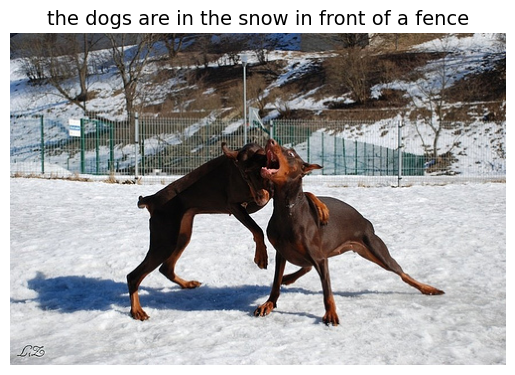

In [38]:
indexes = [word2idx.get(token, 3) for token in test_image_captions[0][0]]
print(indexes)
tokens = [idx2word.get(idx, "<unk>") for idx in indexes]
print(tokens)

#対応する画像
import matplotlib.pyplot as plt
from PIL import Image

# 画像パスを取得
img_path = test_image_paths[0]

# 画像を開く
img = Image.open(img_path).convert("RGB")

# 復元されたトークンを文章に結合
caption_text = " ".join(tokens)

# 表示
plt.imshow(img)
plt.axis("off")
plt.title(caption_text, fontsize=14, wrap=True)
plt.show()



仲良くしてほしいですね。</br>
ここでindexesとtokensで単語→数字変換と数字→単語変換が実装できたことになります。

# Chapter 3: データローダの準備

ではデータローダの準備をします。</br>
データローダはデータセットをミニバッチに分割する方法で、PyTorchでデータを読み込むときの「お作法」でしたね。

In [ ]:
import os, sys

# ノートブックから見て 2 つ上の階層を sys.path に追加
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from utils.caption_util import FlickrD  # ← これでOK

# Dataset
trainset = FlickrD(train_image_paths, train_image_captions, word2idx)
testset  = FlickrD(test_image_paths,  test_image_captions,  word2idx)

FlickrD関数はパスを指定するとそのパスのリストにあるすべてのファイルをとってきて、トークンにしてベクトル化し、そしてそれと同時に画像を必要に応じてサイズを変換し、ベクトル変換します。</br>
これらを一気に実装した関数ですのでコードが気になればコードを覗いてみてください。

In [48]:
#FlickrD関数の出力
trainset[1]

(tensor([[[-0.9192, -1.0390, -1.3987,  ..., -1.1760, -0.9705, -1.2103],
          [-1.4158, -1.1932, -1.5014,  ..., -1.3987, -1.2103, -1.2103],
          [-1.4329, -1.3815, -1.6042,  ..., -1.3987, -1.1247, -1.0219],
          ...,
          [ 1.9749,  1.9407,  1.9064,  ...,  1.5810,  1.2385,  1.2899],
          [ 1.9407,  1.9064,  1.8379,  ...,  1.4783,  1.3070,  1.3070],
          [ 1.7523,  1.8722,  2.0263,  ...,  1.5297,  1.5639,  1.6153]],
 
         [[-1.0203, -1.1253, -1.3529,  ..., -1.1954, -1.0728, -1.2129],
          [-1.4055, -1.2654, -1.5105,  ..., -1.4230, -1.2479, -1.2654],
          [-1.4055, -1.3880, -1.5630,  ..., -1.4055, -1.1779, -1.1078],
          ...,
          [ 2.1485,  2.1310,  2.0784,  ...,  1.7808,  1.5007,  1.5882],
          [ 2.1310,  2.0784,  2.0084,  ...,  1.6758,  1.5532,  1.6057],
          [ 1.9209,  2.0259,  2.2010,  ...,  1.7633,  1.8333,  1.8508]],
 
         [[-0.9678, -1.0376, -1.3164,  ..., -1.1073, -0.9330, -1.1073],
          [-1.3339, -1.1944,

データローダに突っ込みましょう。

In [49]:
from torch.utils.data import DataLoader
import torch

# DataLoader（学習はシャッフル、推論はそのまま）
train_loader = DataLoader(
    trainset, batch_size=128, shuffle=True,
    num_workers=4, pin_memory=True, drop_last=True
)
test_loader = DataLoader(
    testset, batch_size=128, shuffle=False,
    num_workers=2, pin_memory=True
)

# 1バッチ取り出し（画像, 入力トークン, 教師トークン, パディングマスク）
test_images, test_tokens, test_targets, test_mask = next(iter(test_loader))

print(test_images.shape)   # [B, 3, 128, 128]
print(test_tokens.shape)   # [B, max_len-1]
print(test_targets.shape)  # [B, max_len-1]
print(test_mask.shape)     # [B, max_len-1]  (pad=0, 非pad=1)


torch.Size([128, 3, 128, 128])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128, 50])


データローダを保存しておきましょう。

In [50]:
import torch
torch.save((test_images,test_tokens),"files/tests.pt")

前準備はこんな感じです。

# Chapter 4: モデル設計

それではモデルを作っていきます。**画像→パッチ→埋め込み→Transformer** を実装します。</br>
やはりTransformerを利用していきます。

In [56]:
## 0. Imports
import math
import torch
from torch import nn

def show_shape(name, tensor):
    print(f"{name}: shape={tuple(tensor.shape)}  dtype={tensor.dtype}")

#画像をバッチ列に変換
def extract_patches(image_tensor, patch_size=8):
    bs, c, h, w = image_tensor.size()
    unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
    unfolded = unfold(image_tensor)
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c * patch_size * patch_size)
    return unfolded

B, C, H, W = 1, 3, 128, 128
patch_size = 8
sample_img = torch.randn(B, C, H, W)

patches = extract_patches(sample_img, patch_size=patch_size)
show_shape("patches", patches)
assert patches.shape[1] == (H // patch_size) ** 2
assert patches.shape[2] == C * patch_size * patch_size


patches: shape=(1, 256, 192)  dtype=torch.float32


次にpositional  encodingを実装します。</br>
トランスフォーマは各トークンごとの位置を認識する能力がないので、自前の関数を何かしらで定義してそれぞれのトークンの「位置」を伝えるものでした。</br>
今回は古典的（？）な手法である正弦波的位置埋込を実行します。

In [57]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

L, Hdim = patches.shape[1], 192
pos_emb = SinusoidalPosEmb(Hdim)(torch.arange(L))
show_shape("pos_emb(L,H)", pos_emb)


pos_emb(L,H): shape=(256, 192)  dtype=torch.float32


次にAttention Blockを定義します。</br>何回もやったと思いますが穴埋め問題を解きましょう。

In [82]:
class AttentionBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, masking=True):
        super(AttentionBlock, self).__init__()
        self.masking = masking
        self.multihead_attn=nn.MultiheadAttention(hidden_size,
             num_heads=num_heads,
             batch_first=True,
             dropout=0.0)  
    def forward(self, x_in, kv_in, key_mask=None):
        if self.masking:
            bs, l, h = x_in.shape
            mask = torch.triu(torch.ones(l, l,
                     device=x_in.device), 1).bool()  
        else:
            mask = None  
        return self.multihead_attn(x_in, kv_in, kv_in,
             attn_mask=mask,key_padding_mask=key_mask)[0]

class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4,
                 decoder=False, masking=True):
        super(TransformerBlock, self).__init__()
        self.decoder = decoder
        self.norm1 = nn.LayerNorm(hidden_size)
        self.attn1 = AttentionBlock(hidden_size=hidden_size,
                                    num_heads=num_heads,
                                    masking=masking)
        if self.decoder:
            self.norm2 = nn.LayerNorm(hidden_size)
            self.attn2 = AttentionBlock(hidden_size=hidden_size,
                            num_heads=num_heads, masking=False)
        self.norm_mlp = nn.LayerNorm(hidden_size)
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size * 4),
                                 nn.ELU(),
                                 nn.Linear(hidden_size * 4, hidden_size))
    def forward(self, x, input_key_mask=None,
                cross_key_mask=None, kv_cross=None):
        x = self.attn1(x, x, key_mask=input_key_mask) + x  
        x = self.norm1(x)
        if self.decoder:  
            x = self.attn2(x, kv_cross,key_mask=cross_key_mask) + x
            x = self.norm2(x)
        x = self.mlp(x) + x  
        return self.norm_mlp(x)

hidden = 192
L = patches.shape[1]
blk = TransformerBlock(hidden_size=hidden, num_heads=4, decoder=False, masking=False)
x = torch.randn(2, L, hidden)
y = blk(x)
show_shape("transformer_block_out", y)
assert y.shape == x.shape


transformer_block_out: shape=(2, 256, 192)  dtype=torch.float32


ここで使われているELU関数は、ReLU関数の親戚だと思ってください。</br>
本質ではないんですが、関数の様子を見せておきます。ReLUよりも速くて滑らかな関数だとイメージしてほしいです。

数式としては</br>

$$
f(x) =
\begin{cases}
x, & x > 0 \\
\alpha \left( e^x - 1 \right), & x \leq 0
\end{cases}
$$

と記載されます。αを恣意的に設定できるところが特徴です。

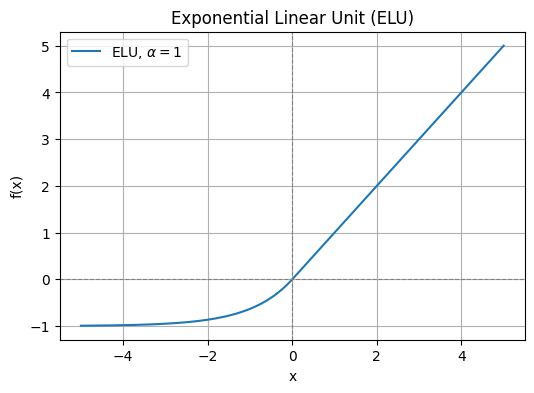

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# ELU関数の定義
def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

# データ生成
x = np.linspace(-5, 5, 400)
y = elu(x, alpha=1.0)

# グラフ描画
plt.figure(figsize=(6, 4))
plt.plot(x, y, label=r"ELU, $\alpha=1$")
plt.axhline(0, color="gray", linewidth=0.8, linestyle="--")
plt.axvline(0, color="gray", linewidth=0.8, linestyle="--")
plt.title("Exponential Linear Unit (ELU)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()


この定義したTransformerブロックを用いて、エンコーダを作成します。

In [83]:
class VisionEncoder(nn.Module):
    def __init__(self, image_size, channels_in,
                 patch_size=16, hidden_size=128,
                 num_layers=6, num_heads=4):
        super(VisionEncoder, self).__init__()
        self.patch_size = patch_size
        self.fc_in = nn.Linear(channels_in*patch_size*patch_size,
                               hidden_size)
        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding=nn.Parameter(torch.empty(1,seq_length,
                              hidden_size).normal_(std=0.02))
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads,
        decoder=False, masking=False) for _ in range(num_layers)
        ]) 
    def forward(self, image):
        bs = image.shape[0]
        patch_seq = extract_patches(image,
              patch_size=self.patch_size)  
        patch_emb = self.fc_in(patch_seq)
        # Add a unique embedding to each token embedding
        embs = patch_emb + self.pos_embedding  
        # Pass the embeddings through each transformer block
        for block in self.blocks:
            embs = block(embs)  
        return embs

encoder = VisionEncoder(image_size=128, channels_in=3, patch_size=8, hidden_size=192, num_layers=3, num_heads=4)
enc_out = encoder(sample_img)
show_shape("encoder_out", enc_out)
assert enc_out.shape == (1, (128 // 8) * (128 // 8), 192)


encoder_out: shape=(1, 256, 192)  dtype=torch.float32


それでさっきの犬の画像でどのように変換されるかを見てみましょう。

In [65]:
if 'test_images' in globals():
    real_batch = test_images[:1]
    real_out = encoder(real_batch)
    show_shape("encoder_out(real_batch)", real_out)
else:
    print("`test_images` が見つからないため、ランダムテンソルで確認しました。")


encoder_out(real_batch): shape=(1, 256, 192)  dtype=torch.float32


In [ ]:
real_out

1

なんかよくわかんないですね、、、</br>
人間からすればわけわからないコードですが、AIにとってはわかりやすい「テンソル」にすることができました。

次にデコーダを整備していきます。</br>
まずはリークを防ぐためのmaskを整備します。復習ですが、transformerの学習時に、過去と自分自身の情報のみにAttentionを許可し、未来の情報をカンニングすることを防ぐ必要があります。

In [69]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

def causal_mask(L: int, device=None, dtype=torch.float32):
    m = torch.full((L, L), float("-inf"), device=device, dtype=dtype)
    m = torch.triu(m, diagonal=1)  # 上三角が -inf、対角含まず
    return m  # [L, L]


デコーダのクラスを定義します。</br>
デコーダの中には文章そのものを生成する関数も定義されています。</br>
この文章を生成する関数はパラメータ更新を凍結させる呪文torch.no_gradを使います。

In [84]:
class Decoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128,
                 num_layers=6, num_heads=4):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(num_emb, hidden_size)
        self.embedding.weight.data=0.001*self.embedding.weight.data
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads,
                             decoder=True) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(hidden_size, num_emb)
    def forward(self, input_seq, encoder_output,
                input_padding_mask=None,
                encoder_padding_mask=None):
        input_embs = self.embedding(input_seq)  #A
        bs, l, h = input_embs.shape
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1,
                             l, h).expand(bs, l, h)
        embs = input_embs + pos_emb  #B
        for block in self.blocks:
            embs = block(embs,
                           input_key_mask=input_padding_mask,
                           cross_key_mask=encoder_padding_mask,
                           kv_cross=encoder_output)  #C
        return self.fc_out(embs) 

まとめて１つのブロックとします。

In [85]:
class VisionEncoderDecoder(nn.Module):
    def __init__(self, image_size, channels_in,
                 num_emb, patch_size=16,
                 hidden_size=128, num_layers=(6,6),
                 num_heads=4):
        super(VisionEncoderDecoder, self).__init__()
        self.encoder = VisionEncoder(
            image_size=image_size, channels_in=channels_in,
            patch_size=patch_size, hidden_size=hidden_size,
            num_layers=num_layers[0], num_heads=num_heads)
        self.decoder = Decoder(num_emb=num_emb,
            hidden_size=hidden_size,
            num_layers=num_layers[1], num_heads=num_heads)
    def forward(self, input_image, target_seq, padding_mask):
        bool_padding_mask = padding_mask == 0  #A
        encoded_seq = self.encoder(image=input_image)  #B
        decoded_seq = self.decoder(input_seq=target_seq,
                         encoder_output=encoded_seq,
                    input_padding_mask=bool_padding_mask)  #C
        return decoded_seq

# Chapter 5: 学習の仕組み

ではいよいよ訓練を進めていきます。</br>
作ったモデルの骨組みをしっかり訓練させましょう。

In [86]:
## 0. Setup
import torch
from torch import nn
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters
hidden_size = 192
num_layers = (6, 6)   # (encoder, decoder)
num_heads = 8
patch_size = 8

#モデルを作成します。
caption_model = VisionEncoderDecoder(
    image_size=128, channels_in=3,
    num_emb=len(word2idx), patch_size=patch_size,
    num_layers=num_layers,hidden_size=hidden_size,
    num_heads=num_heads).to(device)

In [88]:
optimizer = torch.optim.Adam(caption_model.parameters(),
                             lr=0.0001)
scaler = torch.cuda.amp.GradScaler()
loss_fn = nn.CrossEntropyLoss(reduction="none")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [89]:
num_model_params = 0
for param in caption_model.parameters():
    num_model_params += param.flatten().shape[0]
print(f"This model has {num_model_params} parameters")

This model has 9545219 parameters


それではいよいよトレーニングを回していきます。

In [ ]:
from tqdm import tqdm

for epoch in range(0, 1):  #A
    caption_model.train()
    eloss=0
    for images,inputs,outputs,masks in tqdm(train_loader):
        images = images.to(device)
        tokens_in = inputs.to(device)
        padding_mask = masks.to(device)
        target_ids = outputs.to(device)
        with torch.amp.autocast("cuda"):
            pred = caption_model(images, tokens_in,  #B
                                 padding_mask=padding_mask)
            loss = (loss_fn(pred.transpose(1, 2),  #C
                            target_ids) * padding_mask).mean()
        optimizer.zero_grad()
        scaler.scale(loss).backward()  #D
        scaler.step(optimizer)
        scaler.update()
        eloss+=loss.item()
    print(f"epoch {epoch}, loss is {eloss/len(train_loader)}")
torch.save(caption_model.state_dict(),"/content/txt2img/files/caption.pth")

# Chapter 6: 推論（キャプション生成）